# Técnicas de agrupamiento

## Importación de librerías y datos

A continuación, se importan las liberías necesarias para el desarrollo de esta actividad:
* Pandas: Permite la importación de los datos y la realización de transformaciones
* Sklearn: Permite la utilización de modelos ML además de otras métricas asociadas
* Numpy: Permite realizar operaciones matemáticas con los datos
* Matplotlib: Permite mostrar gráficas

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples
from IPython.display import display, Math, Latex

A continuación, se cargan los datos mediante pandas y se obtiene una breve descripción de los datos

In [3]:
data = pd.read_csv("data/Wholesale customers data.csv")
filas, columnas = data.shape
print("El fichero tiene " + str(filas) + " filas y " + str(columnas) + " columnas")
print()
print(data.head())
data.describe()

El fichero tiene 440 filas y 8 columnas

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## Tratamiento de los datos faltantes (Missing Data)

No existen datos faltantes (missing data), por lo que no se realizará ningún tratamiento

In [4]:
data.isnull().values.any()

False

## Otras valoraciones 

Se eliminarán las variables Channel y Region del dataset, dado que estas son campos identificadores que nos serán útiles en la realización de este ejercicio.  
  
Además, existen grandes diferencias entre los valores Mínimos y máximos de los datos (Por ejemplo en Fresh, Grocery, Frozen...). Estos outliers pueden generar una mala clusterización, por lo que se realiza la eliminación de estos. Es por eso que se eliminarán aquellos registros que se encuentren a partir del 95%

Text(0.5, 1.0, 'Delicassen')

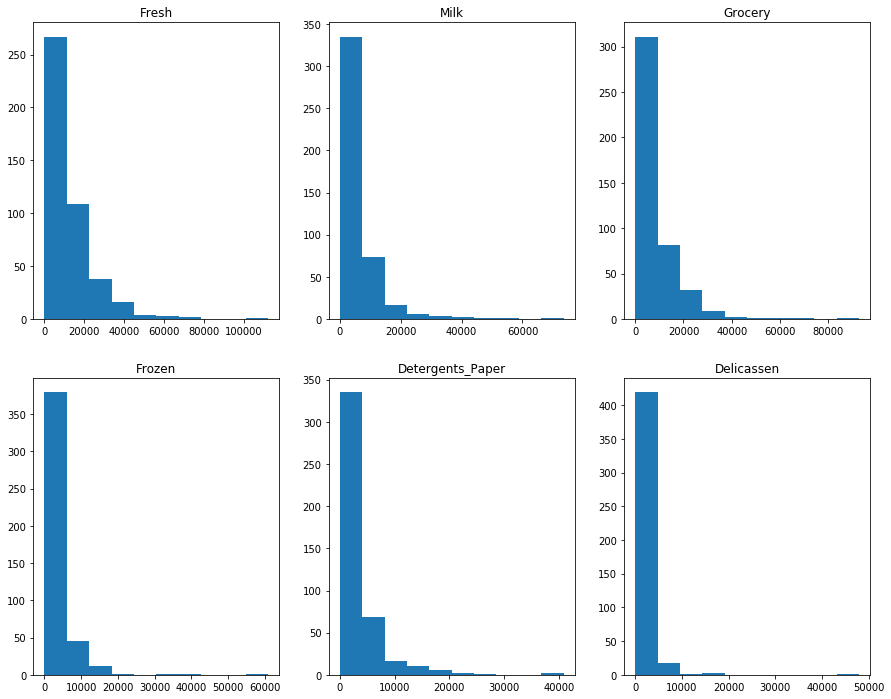

In [5]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
ax1.hist(data.Fresh)
ax1.set_title("Fresh")
ax2.hist(data.Milk)
ax2.set_title("Milk")
ax3.hist(data.Grocery)
ax3.set_title("Grocery")
ax4.hist(data.Frozen)
ax4.set_title("Frozen")
ax5.hist(data.Detergents_Paper)
ax5.set_title("Detergents_Paper")
ax6.hist(data.Delicassen)
ax6.set_title("Delicassen")

Text(0.5, 1.0, 'Delicassen')

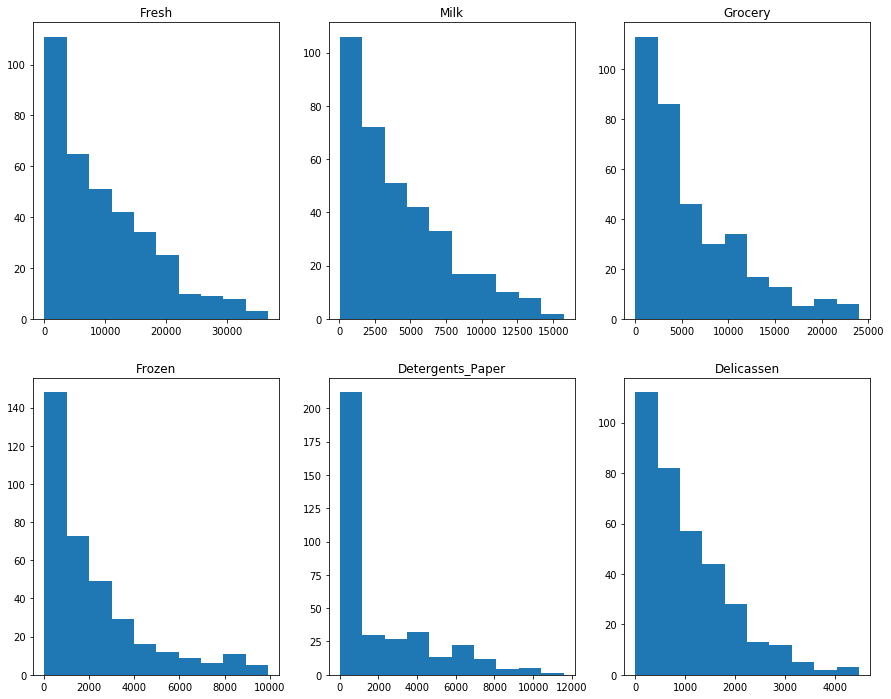

In [6]:
limit_fresh = data.quantile(.95)["Fresh"]
limit_milk = data.quantile(.95)["Milk"]
limit_grocery = data.quantile(.95)["Grocery"]
limit_frozen = data.quantile(.95)["Frozen"]
limit_detergents_paper = data.quantile(.95)["Detergents_Paper"]
limit_delicassen = data.quantile(.95)["Delicassen"]

data_filtered = data[
    (data.Fresh <limit_fresh) & (data.Milk < limit_milk) & (data.Grocery < limit_grocery) & (data.Frozen < limit_frozen) &
    (data.Detergents_Paper < limit_detergents_paper) & (data.Delicassen < limit_delicassen)
]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
ax1.hist(data_filtered.Fresh)
ax1.set_title("Fresh")
ax2.hist(data_filtered.Milk)
ax2.set_title("Milk")
ax3.hist(data_filtered.Grocery)
ax3.set_title("Grocery")
ax4.hist(data_filtered.Frozen)
ax4.set_title("Frozen")
ax5.hist(data_filtered.Detergents_Paper)
ax5.set_title("Detergents_Paper")
ax6.hist(data_filtered.Delicassen)
ax6.set_title("Delicassen")

## Normalización de los datos

Se normaliza la información para aplicar las técnicas de búsqueda de K y para la aplicación posterior del K-Means

In [7]:
df_norm = (data_filtered-data_filtered.min())/(data_filtered.max()-data_filtered.min())
df_norm.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.344054,0.612543,0.314982,0.019087,0.230776,0.298324
1,1.0,1.0,0.191612,0.622368,0.398625,0.175419,0.284258,0.396201
3,0.0,1.0,0.360243,0.072796,0.175787,0.644213,0.043546,0.398883
5,1.0,1.0,0.255609,0.523415,0.213503,0.064734,0.154830,0.323575
6,1.0,1.0,0.329304,0.200587,0.290561,0.045950,0.271039,0.121117


A continuación, se obtiene el vector de características en base a los datos

In [8]:
features = ["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]
_X = df_norm[features]


## Búsqueda de K (número de clusters)

La problemática principal del uso de K-means es que hay que saber con anterioridad el número de clusters en el que se desea clasificar los datos. Por ello, se hará uso de varías técnicas para la obtención de este número.

### Regla matemática

Una de las técnicas más usadas es el uso de la función expuesta más abajo, donde se utiliza el número de los datos para determinar el número de clusters necesarios

In [9]:
display(Math(r'k = \sqrt{\frac{n}{2}}'))

<IPython.core.display.Math object>

In [10]:
_k = np.sqrt(len(df_norm)/2)
print("Número de clusters: " + str(round(_k, 0)))

Número de clusters: 13.0


### Tecnica de la silueta

Otras de las ténicas más usadas para establecer el número de clusters es la técnica de la silueta (*Silhouette*)  
Esta técnica permite saber como de parecido es un objeto a su cluster en comparación con el resto de clusters. 
  
Para el uso de esta técnica, se define un número máximo de clústers. Como anteriormente se ha obtenido el valor de 15, se definen hasta un máximo de 20 clusters. A continuación se definen los pasos usados para esta implementación:

1. Se realiza un bucle iterando sobre este número máximo definido, con le objetivo de generar distintos modelos con distintos números de clusters.  
2. Se hace un cálculo de la distintancia entre los datos y los centroides calculados, haciendo uso de la librería *cdist* mediante el uso de la distancia *euclidea*. Esto también es denominado Sum of Squared Within (SSW), y evalua la cohesión de los clústeres. Será usado para la técnica del codo usada posteriormente. Est
3. Se utiliza la función *silhouette_score* y la función *silhouette_samples*, las cuales darán la silueta a dibujar y el promedio de la silueta para cada cluster.
4. Después, mediante otro bucle, se recorre cada uno de los clusters generados en cada modelo para pintar las distintas siluetas 
5. Se accede a la etiqueta de cada silueta generada, y se pinta, dejando una separación de 10 posiciones entre silueta

* Para k =  2  el promedio de la silueta es de : 0.3515426290704583
* Para k =  3  el promedio de la silueta es de : 0.2882182741010675
* Para k =  4  el promedio de la silueta es de : 0.32758115411851185
* Para k =  5  el promedio de la silueta es de : 0.2786833600845176
* Para k =  6  el promedio de la silueta es de : 0.25671897570962937
* Para k =  7  el promedio de la silueta es de : 0.2498920904056585
* Para k =  8  el promedio de la silueta es de : 0.20722537426428897
* Para k =  9  el promedio de la silueta es de : 0.23076232398010077
* Para k =  10  el promedio de la silueta es de : 0.20502024324075346
* Para k =  11  el promedio de la silueta es de : 0.19163787844432223
* Para k =  12  el promedio de la silueta es de : 0.19484842065276678
* Para k =  13  el promedio de la silueta es de : 0.2018106821071276
* Para k =  14  el promedio de la silueta es de : 0.1982800534946538
* Para k =  15  el promedio de la silueta es de : 0.19415580486594242
* Para k =  16  el promedio de la 

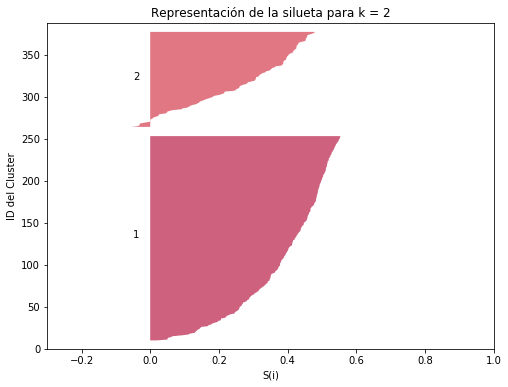

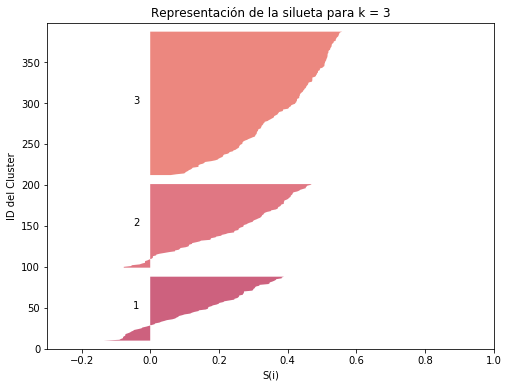

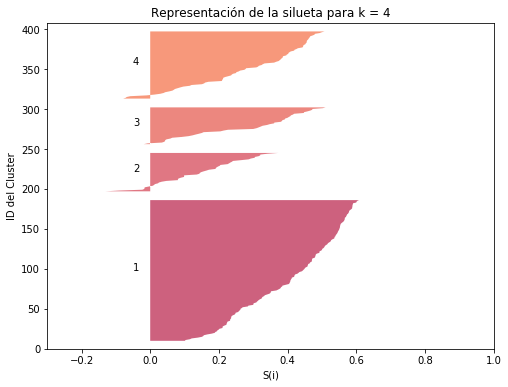

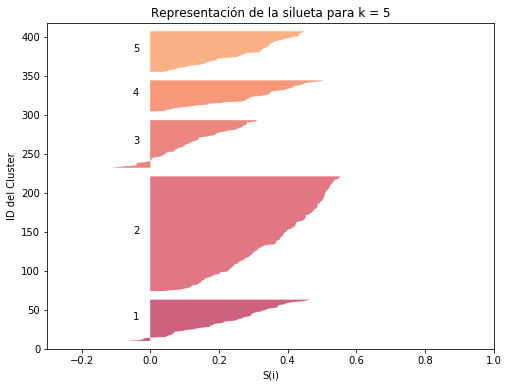

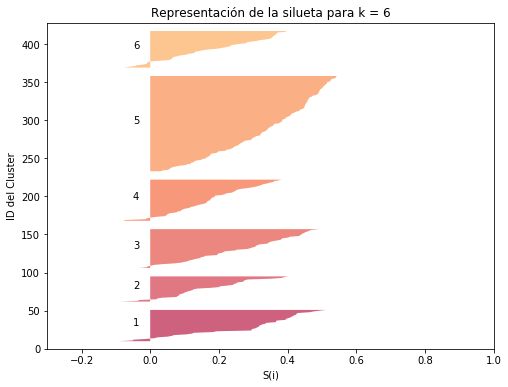

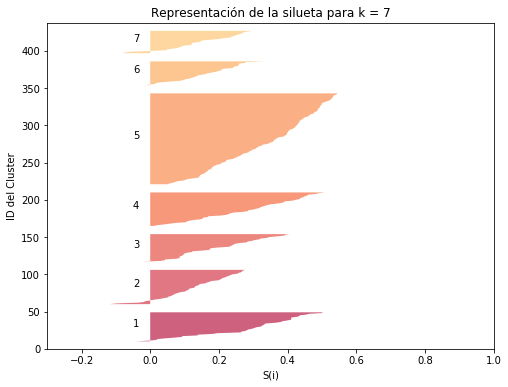

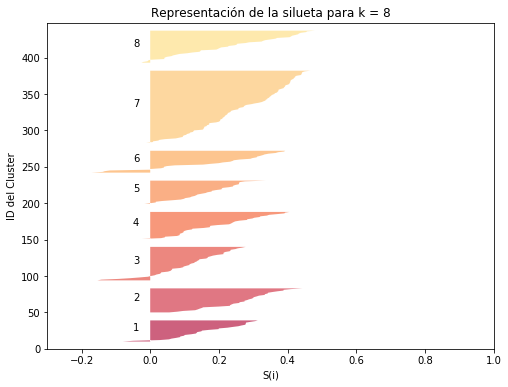

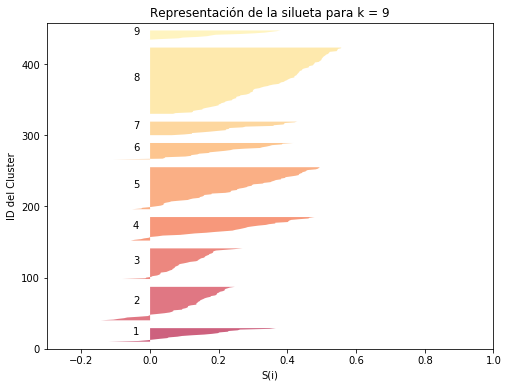

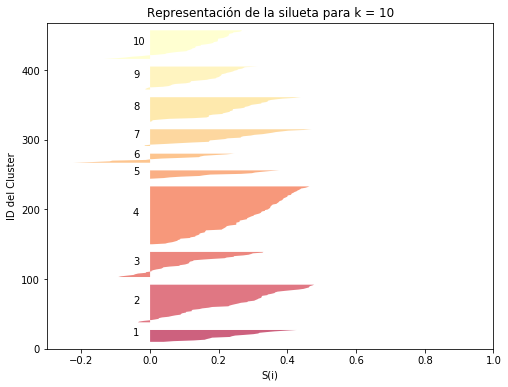

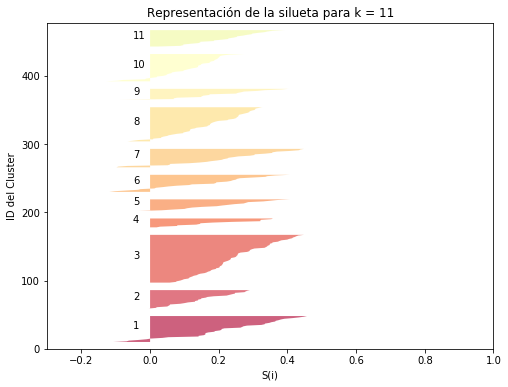

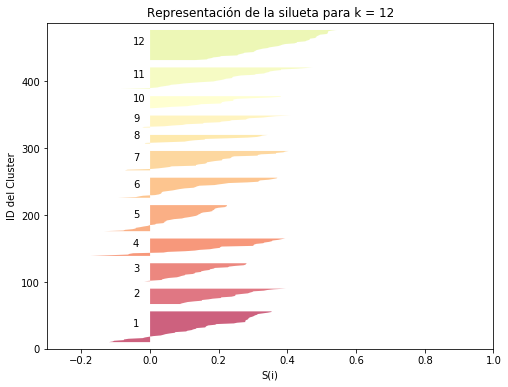

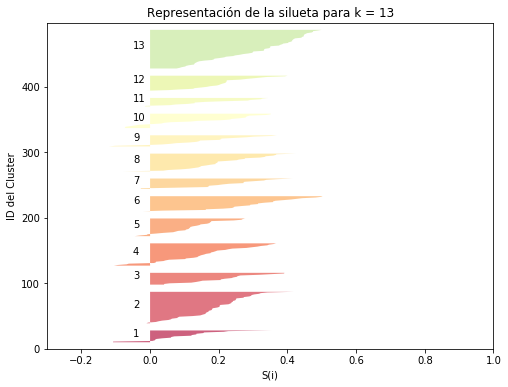

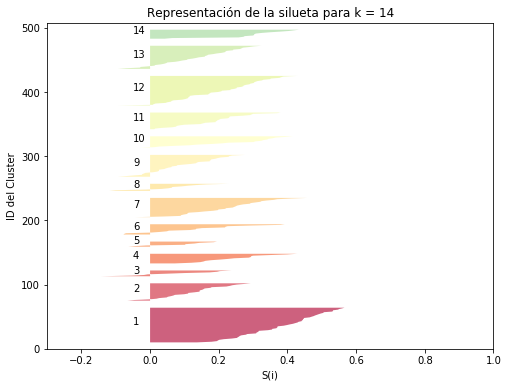

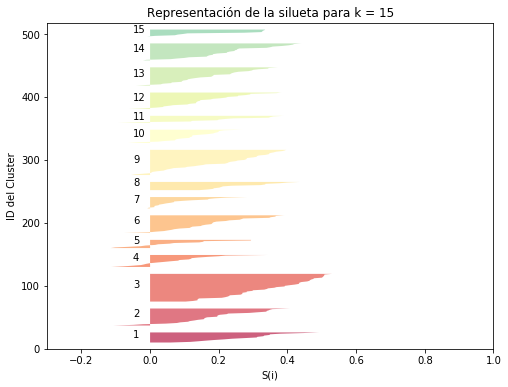

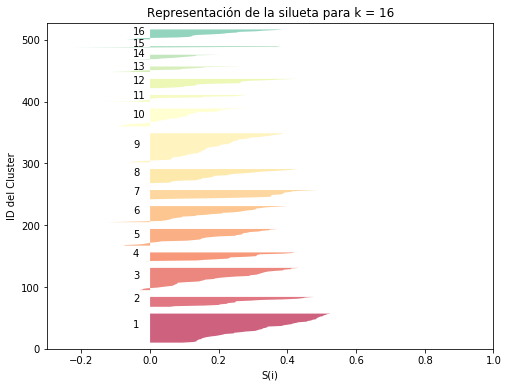

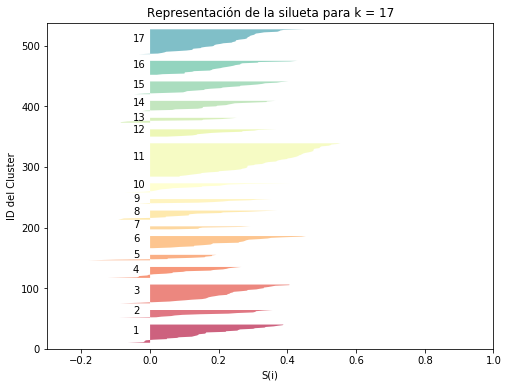

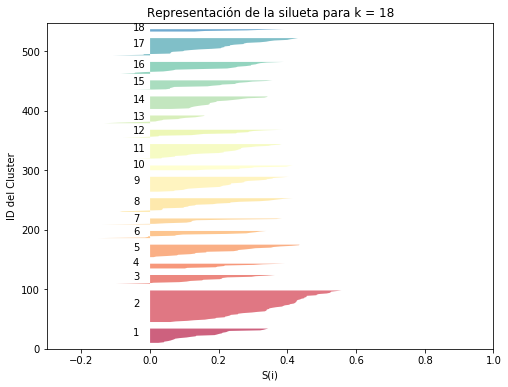

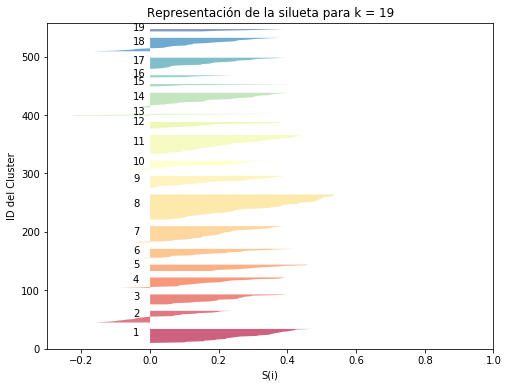

In [9]:
import warnings
# Se define el número máximo de clusters.
# Se escoge 20 dado que la regla anterior nos da un total de 15
max_k = 20
# Se pasa de dataframe a array para poder usar las funciones
X = _X.values
# Se genera un rango para el bucle
K = range(1, max_k)
# Variable que almacenará los datos para la técnica del codo
ssw = []
# Se define una paleta de colores para cada modelo que se va a crear
color_palette = [plt.cm.get_cmap("Spectral")(float(i)/max_k) for i in K]

# Se recorre hasta el número máximo de clusters
for k in K:
    # Se genera un modelo para cada iteración
    kmeansModel = KMeans(n_clusters=k).fit(X)
    # Se obtiene los labels del modelo generado
    labels = kmeansModel.labels_
    # Se calcula la distancia euclidea de cada punto al centro del cluster
    # Se utiliza la función min para obtener la del cluster al que pertenece
    ssw_k = sum(np.min(cdist(X,kmeansModel.cluster_centers_, "euclidean"), axis=1))
    ssw.append(ssw_k)
    # Se genera una paleta de colores para cada cluster del modelo
    label_color = [color_palette[i] for i in labels]
    
    # La generación de una silueta para un único cluster falla, por lo que se filtra
    if 1<k<len(X):
        # Se genera una figura con un plot para la visualización de la silueta
        fig, (axis1) = plt.subplots(1,1)
        fig.set_size_inches(8,6)
    
        axis1.set_xlim([-0.3, 1.0])
        #El número de clusters a insertar determinará el tamaño de cada barra
        #El coeficiente (n_clusters+1)*10 será el espacio en blanco que dejaremos 
        #entre siluetas individuales de cada cluster para separarlas.
        axis1.set_ylim([0, len(X)+ (k+1)*10])
        
        silhouette_avg = silhouette_score(X, labels)
        print("* Para k = ",k, " el promedio de la silueta es de :",silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, labels)
        
        y_lower = 10
        for i in range(k):
            #Agregamos la silueta del cluster i-ésimo
            ith_cluster_sv = sample_silhouette_values[labels == i]
            #Ordenamos descendientemente las siluetas del cluster i-ésimo
            ith_cluster_sv.sort()
        
            #Calculamos donde colocar la primera silueta en el eje vertical
            ith_cluster_size = ith_cluster_sv.shape[0]
            y_upper = y_lower + ith_cluster_size
            
            #Elegimos el color del cluster
            color = color_palette[i]
            
            # Se pinta la silueta del cluster i
            axis1.fill_betweenx(np.arange(y_lower, y_upper),
                               0, ith_cluster_sv, facecolor = color, alpha = 0.7)
            
            
            # Se pone el número del cluster (i+1) en el medio
            axis1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i+1))
            
            # Se calcula la posicion de la proxima silueta, dejando 10 de espacio
            y_lower = y_upper + 10
                        
        axis1.set_title("Representación de la silueta para k = %s"%str(k))
        axis1.set_xlabel("S(i)")
        axis1.set_ylabel("ID del Cluster")
                

Como se puede observar, el mejor valor de silueta obtenido es para un modelo realizado con 4 clústers.

## Técnica del Codo

Esta ténica permite identificar la cohesión existente en función del número de clusters generados. En caso de existir un cluster para cada dato (K=N), la ssw (distancia del dato al centroide) sería mínima.  
El objetivo de esta técnica es encontrar un punto a partir del cual no existe una ganancia significativa al agregar un nuevo cluster al modelo. Normalmente esto se identifica porque en ese punto, la grafica tiene aspecto de un codo humano

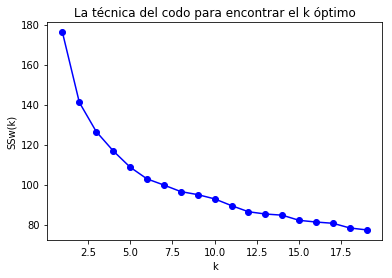

In [10]:
plt.plot(K, ssw, "bo-")
plt.xlabel("k")
plt.ylabel("SSw(k)")
plt.title("La técnica del codo para encontrar el k óptimo")
plt.show()

Como se puede ver en la gráfica anterior, a partir de 4-5 clusters, no se tiene una ganancia significativa respecto a la cohesión del modelo

En combinación de las 3 técnicas usadas, se puede decir que el **uso de 5 clusters** es la forma en la que se tiene los datos mejor distribuidos

## Generación del modelo

Tras obtener el número de clusters (K) para el desarrollo del modelo, se procede a su desarrollo:

In [11]:
model = KMeans(n_clusters=5, random_state=1)
model.fit(_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

Con el modelo ya generado, se obtiene el cluster asignado para cada uno de los datos a partir de la variable *.labels_*

In [12]:
df_norm["clust_k"] = pd.Series(model.labels_)
df_norm.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clust_k
0,1.0,1.0,0.344054,0.612543,0.314982,0.019087,0.230776,0.298324,2.0
1,1.0,1.0,0.191612,0.622368,0.398625,0.175419,0.284258,0.396201,2.0
3,0.0,1.0,0.360243,0.072796,0.175787,0.644213,0.043546,0.398883,2.0
5,1.0,1.0,0.255609,0.523415,0.213503,0.064734,0.154830,0.323575,2.0
6,1.0,1.0,0.329304,0.200587,0.290561,0.045950,0.271039,0.121117,4.0


Mediante el atributo *inertia_* se puede obtener la suma al cuadrado de las distancias de cada punto al centroide del cluster al que pertenece.

In [13]:
print(model.inertia_)

39.14455158533474


Text(0.5, 1.0, 'Frozen vs Delicassen')

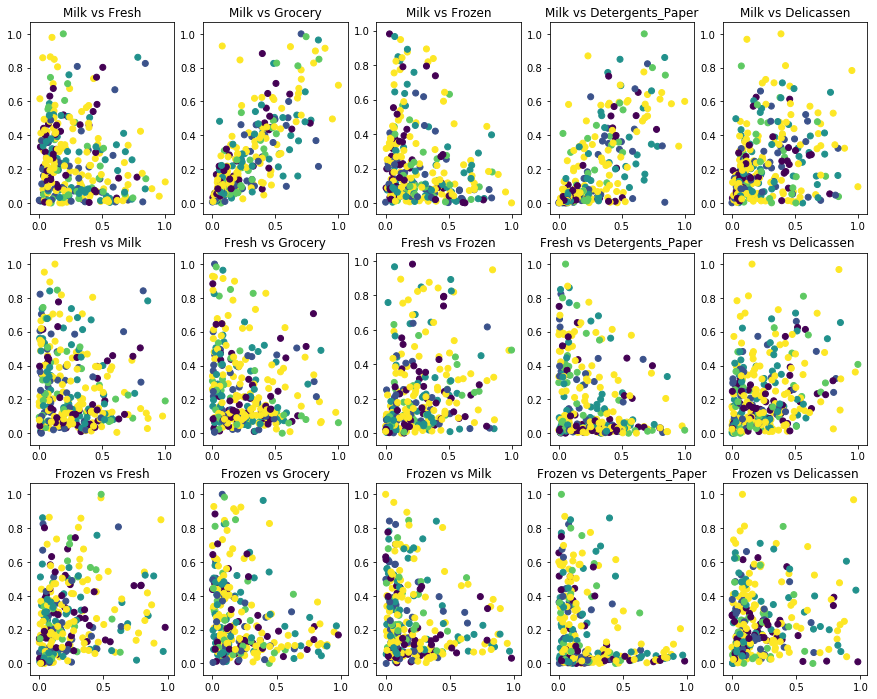

In [16]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6 ,ax7, ax8, ax9 ,ax10), (ax11 ,ax12, ax13, ax14 ,ax15)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
ax1.scatter(df_norm["Milk"], df_norm["Fresh"], c=df_norm["clust_k"])
ax1.set_title("Milk vs Fresh")
ax2.scatter(df_norm["Milk"], df_norm["Grocery"], c = df_norm["clust_k"])
ax2.set_title("Milk vs Grocery")
ax3.scatter(df_norm["Milk"], df_norm["Frozen"], c = df_norm["clust_k"])
ax3.set_title("Milk vs Frozen")
ax4.scatter(df_norm["Milk"], df_norm["Detergents_Paper"], c = df_norm["clust_k"])
ax4.set_title("Milk vs Detergents_Paper")
ax5.scatter(df_norm["Milk"], df_norm["Delicassen"], c = df_norm["clust_k"])
ax5.set_title("Milk vs Delicassen")
ax6.scatter(df_norm["Fresh"], df_norm["Milk"], c = df_norm["clust_k"])
ax6.set_title("Fresh vs Milk")
ax7.scatter(df_norm["Fresh"], df_norm["Grocery"], c = df_norm["clust_k"])
ax7.set_title("Fresh vs Grocery")
ax8.scatter(df_norm["Fresh"], df_norm["Frozen"], c = df_norm["clust_k"])
ax8.set_title("Fresh vs Frozen")
ax9.scatter(df_norm["Fresh"], df_norm["Detergents_Paper"], c = df_norm["clust_k"])
ax9.set_title("Fresh vs Detergents_Paper")
ax10.scatter(df_norm["Fresh"], df_norm["Delicassen"], c = df_norm["clust_k"])
ax10.set_title("Fresh vs Delicassen")
ax11.scatter(df_norm["Frozen"], df_norm["Fresh"], c=df_norm["clust_k"])
ax11.set_title("Frozen vs Fresh")
ax12.scatter(df_norm["Frozen"], df_norm["Grocery"], c = df_norm["clust_k"])
ax12.set_title("Frozen vs Grocery")
ax13.scatter(df_norm["Frozen"], df_norm["Milk"], c = df_norm["clust_k"])
ax13.set_title("Frozen vs Milk")
ax14.scatter(df_norm["Frozen"], df_norm["Detergents_Paper"], c = df_norm["clust_k"])
ax14.set_title("Frozen vs Detergents_Paper")
ax15.scatter(df_norm["Frozen"], df_norm["Delicassen"], c = df_norm["clust_k"])
ax15.set_title("Frozen vs Delicassen")

Por último, se visualiza la forma en la que los datos se distribuyen entre los distintos clusters

Text(0.5, 1.0, 'K vs Milk')

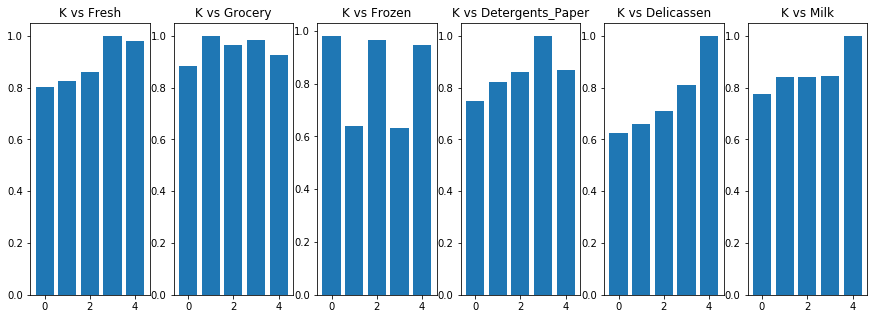

In [20]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))
ax1.bar(df_norm["clust_k"], df_norm["Fresh"])
ax1.set_title("K vs Fresh")
ax2.bar(df_norm["clust_k"], df_norm["Grocery"])
ax2.set_title("K vs Grocery")
ax3.bar(df_norm["clust_k"], df_norm["Frozen"])
ax3.set_title("K vs Frozen")
ax4.bar(df_norm["clust_k"], df_norm["Detergents_Paper"])
ax4.set_title("K vs Detergents_Paper")
ax5.bar(df_norm["clust_k"], df_norm["Delicassen"])
ax5.set_title("K vs Delicassen")
ax6.bar(df_norm["clust_k"], df_norm["Milk"])
ax6.set_title("K vs Milk")